# Installing Modules

In [1]:
# Installing Modules
!pip install wandb -qU
!pip install pytorch_lightning



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.6 MB/s eta 0:00:00


# Drive Mount

In [2]:

# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Importing Modules


In [3]:
# Importing Modules

import wandb
import torch 
import pytorch_lightning as pl
import torch.nn as nn
from torch.nn  import functional
from pytorch_lightning.loggers import WandbLogger
from matplotlib.font_manager import FontProperties
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import random
import csv
import pandas as pd
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt




# Unzip data

In [4]:
#Unzip aksharantar_sampled data 
!unzip /content/drive/MyDrive/dl/aksharantar_sampled.zip
# !unzip Tiro_Devanagari_Hindi.zip -d hindi

Archive:  /content/drive/MyDrive/dl/aksharantar_sampled.zip
   creating: aksharantar_sampled/
   creating: aksharantar_sampled/asm/
  inflating: aksharantar_sampled/asm/asm_test.csv  
  inflating: aksharantar_sampled/asm/asm_train.csv  
  inflating: aksharantar_sampled/asm/asm_valid.csv  
   creating: aksharantar_sampled/ben/
  inflating: aksharantar_sampled/ben/ben_test.csv  
  inflating: aksharantar_sampled/ben/ben_train.csv  
  inflating: aksharantar_sampled/ben/ben_valid.csv  
   creating: aksharantar_sampled/brx/
  inflating: aksharantar_sampled/brx/brx_test.csv  
  inflating: aksharantar_sampled/brx/brx_train.csv  
  inflating: aksharantar_sampled/brx/brx_valid.csv  
   creating: aksharantar_sampled/guj/
  inflating: aksharantar_sampled/guj/guj_test.csv  
  inflating: aksharantar_sampled/guj/guj_train.csv  
  inflating: aksharantar_sampled/guj/guj_valid.csv  
   creating: aksharantar_sampled/hin/
  inflating: aksharantar_sampled/hin/hin_test.csv  
  inflating: aksharantar_sampled

# Connecting Wandb


In [16]:
# Connecting to Wandb
wandb.login(key="8d6c17aa48af2229c26cbc16513ef266358c0b96")
wandb.init(project="Assignment-03-image")
hindi_font = FontProperties(fname = 'TiroDevanagariHindi-Regular.ttf')


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


# Data Loading

In [6]:
lang = "hin" # name of the lang to train the model
base_dir = "aksharantar_sampled/" # root dir containing all the lang datasets

base_dir = base_dir+lang+"/" 

train_file = base_dir+lang+"_train.csv"
val_file = base_dir+lang+"_valid.csv"
test_file = base_dir+lang+"_test.csv"

# loading train,valid,test csv files
train_data = pd.read_csv(train_file,header=None)
val_data = pd.read_csv(val_file,header=None)
test_data = pd.read_csv(test_file,header=None)


# Initialization of special tokens in Character dictionaries
latin_chars = {'<PAD>': 0, '<UNK>': 1,'<start>':2,'<end>':3}
lang_chars = {'<PAD>': 0, '<UNK>': 1,'<start>':2,'<end>':3}
latin_chars_num = {}
lang_chars_num = {}

# Character counting and numbering
for word in train_data[0]:
  for char in word :
    if char not in latin_chars:
      latin_chars[char] = len(latin_chars)

for word in train_data[1]:
  for char in word :
    if char not in lang_chars:
      lang_chars[char] = len(lang_chars)

# Reverse dictionaries
for key,value in latin_chars.items():
  latin_chars_num[value] = key

for key,value in lang_chars.items():
  lang_chars_num[value] = key

# Maximum word length
latin_max_length = len(max(train_data[0],key = len))
lang_max_length = len(max(train_data[1],key = len))

In [7]:
#Device selection
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def word_to_vec(data):
  data1= data.T
  data_pairs = []
  for i in range(0,len(data)):  # Iterating over data
    # Encoding words
    word =  [2]+[latin_chars.get(char,latin_chars['<UNK>']) for char in data1[i][0]] + [0]*(latin_max_length - len(data1[i][0]))+[3]
    word = word[:latin_max_length+2]
    latin_tensor = torch.tensor(word).to(device)
    word =  [2]+[lang_chars.get(char,lang_chars['<UNK>']) for char in data1[i][1]] + [0]*(lang_max_length - len(data1[i][1]))+[3]
    lang_tensor = torch.tensor(word).to(device)
    # Building data pairs
    data_pairs.append([latin_tensor,lang_tensor])
  # Returning data pairs
  return data_pairs 

# DataLoader

In [8]:
# Conversion to Encoded word pairs
train_data_pairs = word_to_vec(train_data)
val_data_pairs = word_to_vec(val_data)
test_data_pairs = word_to_vec(test_data)

# Data loaders and Batch size and shuffling
train_dataloader = DataLoader(train_data_pairs, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data_pairs, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data_pairs, batch_size=64, shuffle=False)


# Encoder

In [ ]:
class Encoder(nn.Module):
  ''' This is the model class used to define the Encoder structure and to train the neural network on given parameters'''
  def __init__(self,input_size,embedding_size,hidden_size,layers,cell_type,bidirectional,dropout):
    '''
      input_size: The size of the input vocabulary or the number of distinct tokens.
      embedding_size: The size of the embedding vectors for each token.
      hidden_size: The size of the hidden state of the RNN cell.
      layers: The number of layers in the RNN.
      cell_type: The type of the RNN cell (nn.RNN, nn.GRU, nn.LSTM).  
      bidirectional: A boolean flag indicating whether the RNN is bidirectional or not.
      dropout: The dropout probability for the RNN layers
    '''
    super(Encoder,self).__init__()
    self.cell_type = cell_type
    self.embedding = nn.Embedding(input_size,embedding_size)
    self.rnn = cell_type(embedding_size,hidden_size,layers,bidirectional = bidirectional,dropout=dropout)
  # Forward method
  def forward(self,x):
    embedding = self.embedding(x)
    output,hidden = self.rnn(embedding)

    return hidden


# Decoder

In [ ]:
class Decoder(nn.Module):
  ''' This is the model class used to define the Decoder structure and to train the neural network on given parameters'''
  def __init__(self,output_size,embedding_size,hidden_size,layers,cell_type,bidirectional,dropout):
    '''
      output_size: The size of the output vocabulary or the number of distinct tokens.
      embedding_size: The size of the embedding vectors for each token.
      hidden_size: The size of the hidden state of the RNN cell.
      layers: The number of layers in the RNN.
      cell_type: The type of the RNN cell (nn.RNN, nn.GRU, nn.LSTM).  
      bidirectional: A boolean flag indicating whether the RNN is bidirectional or not.
      dropout: The dropout probability for the RNN layers
    '''
    super(Decoder,self).__init__()
    self.cell_type = cell_type
    self.embedding = nn.Embedding(output_size,embedding_size) 
    self.rnn = cell_type(embedding_size,hidden_size,layers,bidirectional = bidirectional,dropout=dropout)
    if bidirectional:
      self.out = nn.Linear(hidden_size*2,output_size) 
    else :
      self.out = nn.Linear(hidden_size,output_size) 

  # Forward method
  def forward(self,x,hidden):
    x = x.unsqueeze(1).transpose(0,1)
    embedding = self.embedding(x)
    output,hidden = self.rnn(embedding,hidden)
    output = self.out(output.squeeze(0))

    return output,hidden




# Model

In [ ]:

# This is the model class used to define the seq2seq model with encoder and decoder structure and to train the neural network on given parameters
# Implements a sequence-to-sequence model using an encoder-decoder architecture and provides methods for training, validation, testing, and prediction. 
# It supports teacher forcing during training and beam search during inference 

class seq2seq(pl.LightningModule):
  def __init__(self,input_size,output_size,embedding_size,hidden_size,encoder_layer_size,decoder_layer_size,cell_type,beam_width,dropout,bidirectional,learning_rate=0.0001):
    '''
      input_size: The size of the input vocabulary or the number of distinct tokens.
      output_size: The size of the output vocabulary or the number of distinct tokens.
      embedding_size: The size of the embedding vectors for each token.
      hidden_size: The size of the hidden state of the RNN cells in the encoder and decoder.
      encoder_layer_size: The number of layers in the encoder.
      decoder_layer_size: The number of layers in the decoder.
      cell_type: The type of the RNN cell (nn.RNN, nn.GRU, nn.LSTM).  
      beam_width: The width of the beam search during inference.
      dropout: The dropout probability for the RNN layers.
      bidirectional: A boolean flag indicating whether the RNN layers are bidirectional or not.
      learning_rate: The learning rate for the optimizer (default is 0.0001)
    '''
    super(seq2seq,self).__init__()
    self.output_size = output_size
    self.lang_max_length = lang_max_length+2
    self.latin_max_length = latin_max_length+2
    self.cell_type = cell_type
    self.train_step_acc = []
    self.train_step_loss = []
    self.val_step_acc = []
    self.val_step_loss = []
    self.decoder_layer_size = decoder_layer_size #*  2 if bidirectional else 1
    self.bidirectional = bidirectional
    self.encoder_layer_size = encoder_layer_size 
    self.beam_width = beam_width
    self.encoder = Encoder(input_size,embedding_size,hidden_size,encoder_layer_size,cell_type,bidirectional,dropout)
    self.decoder = Decoder(output_size,embedding_size,hidden_size,decoder_layer_size,cell_type,bidirectional,dropout)
    self.learning_rate = learning_rate

  def beam_search(self,hidden,input,beam_width,output_len,output_seq):
    queue = []
    queue.append((input,1,hidden))
    for t in range(output_len):
      queue_temp = []
      for i in range(len(queue)):
        (input,prob_parent,hidden) = queue[i]
        output_rnn,hidden = self.decoder( input ,hidden)
        prob , index = torch.topk(output_rnn,beam_width)
        output_rnn = output_rnn.squeeze(1)
        for j in range(beam_width):
          prob_score = prob_parent*prob[0][j]
          if (prob_score > 1e-5):
            queue_temp.append((torch.tensor([index[0][j]]).to(device),prob_score,hidden))
      output_seq[t] = output_rnn
      queue = sorted(queue_temp,key = lambda x:x[1] , reverse = True)[:beam_width]
    return  output_seq

  def forward(self,input,output = [],tf = 0.5) :
    '''
    The forward method defines the forward pass of the seq2seq model. 
    It takes an input tensor input, an optional output tensor output, and a teacher-forcing ratio tf as inputs
    '''
    batch_size = input.shape[0]
    output_size = self.output_size

    bidir = 2 if self.bidirectional else 1
    hidden = self.encoder(input.transpose(0,1))
    if self.encoder_layer_size > self.decoder_layer_size :
      if (self.cell_type == nn.LSTM):
        (hidden,cell) = hidden
        hidden = hidden[-1*self.decoder_layer_size* bidir :]
        cell = cell[-1*self.decoder_layer_size*  bidir:]
        hidden = (hidden,cell) 
      else:
        hidden = hidden[-1*self.decoder_layer_size* bidir:]
        
    elif self.encoder_layer_size < self.decoder_layer_size :
      cell = []
      if (self.cell_type == nn.LSTM):
        (hidden,cell) = hidden
        temp_hidden = hidden[-1 *bidir:]
        temp_cell = cell[-1 *bidir:]
        if(temp_hidden.shape[0] == 0) :
            temp_hidden = hidden
            temp_cell = cell
        for i in range(self.decoder_layer_size - self.encoder_layer_size):   
          hidden = torch.cat((hidden,temp_hidden) )
          cell = torch.cat((cell,temp_cell))
        hidden = (hidden,cell) 
      else :
        temp_hidden = hidden[-1 *bidir:]
        if(temp_hidden.shape[0] == 0) :
            temp_hidden = hidden
        for i in range(self.decoder_layer_size - self.encoder_layer_size):   
          hidden = torch.cat((hidden,temp_hidden),dim=0 )
    
    output_seq = torch.zeros(self.lang_max_length,batch_size,output_size).to(device)
    if tf > 0:
      output = output.transpose(0,1)
    next_input = torch.tensor([2]*batch_size).to(device)
    


    # Iterates over the decoding steps,probabilities for each time step. The output probabilities are stored in the output sequence tensor
    if self.beam_width == 1:
      for t in range(self.lang_max_length):
        output_rnn,hidden = self.decoder( next_input ,hidden)
        output_seq[t] = output_rnn.squeeze(1)
        next_input =  output_seq[t].argmax(1) if  tf < torch.rand(1).item() else output[:,t]
      return output_seq
    else :
      for i in range(batch_size):
        output_seq_temp = torch.zeros(output.shape[1],1,output_size).to(device)
        # print(hidden.shape,next_input.shape,batch_size)
        # print(hidden[:,i,:]..shape)
        output_seq_temp = self.beam_search(hidden[:,i:i+1,:],next_input[i:i+1],self.beam_width,output.shape[1],output_seq_temp)
        output_seq[:,i:i+1,:] = output_seq_temp
      return output_seq


  def training_step(self,batch):
    '''
    The training_step method is called during the training loop for each batch of data. 
    It takes a batch of input-output pairs as input
    '''
    input,output = batch

    output = output.permute(1,0)
    # Calling forward 
    output_seq = self(input,output)
    output = output.permute(1,0)

    output_seq_2 = torch.zeros(output_seq.shape).to(device)
    batch_n = np.arange(len(output_seq))

    for f in range(len(output)):
      col = output[f]
      output_seq_2[batch_n,f,np.array(col.cpu())] = 1
    output_dim = output_seq.shape[-1]
    output_seq_t1 = output_seq[1:].view(-1,output_dim)
    output_seq_t2 = output_seq_2[1:].view(-1,output_dim)

    # Computing the cross-entropy loss between the predicted output sequence and the true output sequence
    loss = nn.CrossEntropyLoss()
    loss = loss(output_seq_t1,output_seq_t2).mean()
    output = output.permute(1,0)

    # Computing the accuracy by comparing the predicted output with the true output.
    output_ = torch.argmax(output_seq,2)
    acc_1 = torch.all(output_[1:-1,:] == output[1:-1,:],dim=0)
    acc = torch.sum(acc_1 == True)/len(acc_1)

    # Logging the loss and accuracy metrics using the self.log method.
    self.log('train_loss', loss,on_epoch = True,on_step = False,prog_bar=True)
    self.train_step_loss.append(loss)
    self.log('train_acc', acc,on_epoch = True,on_step = False,prog_bar=True)
    self.train_step_acc.append(acc)

    return loss



  def on_train_epoch_end(self):
    '''
    The on_train_epoch_end method is called at the end of each training epoch. 
    It calculates the average training loss and accuracy over the epoch, as well as the average validation loss and accuracy .
    '''
    train_acc =  torch.stack(self.train_step_acc).mean()
    train_loss =  torch.stack(self.train_step_loss).mean()
    val_acc =  torch.stack(self.val_step_acc).mean()
    val_loss =  torch.stack(self.val_step_loss).mean()
    print("train_loss:",train_loss.item(),"train_acc",train_acc.item(),"val_loss:",val_loss.item(),"val_acc",val_acc.item())
    # wandb.log({"train_loss":train_loss.item(),"train_acc":train_acc.item(),"val_loss":val_loss.item(),"val_acc":val_acc.item()})
    self.train_step_acc.clear() 
    self.train_step_loss.clear() 
    self.val_step_acc.clear() 
    self.val_step_loss.clear() 


  def validation_step(self, batch,batch_idx):
    '''
    The validation_step method is similar to the training_step method but is called during the validation loop for each batch of data.
    It computes the loss and accuracy metrics for the validation data
    '''
    input,output = batch
    output = output.permute(1,0)
    output_seq = self(input,output,0)
    output = output.permute(1,0)

    output_seq_2 = torch.zeros(output_seq.shape).to(device)
    batch_n = np.arange(len(output_seq))

    for f in range(len(output)):
      col = output[f]
      output_seq_2[batch_n,f,np.array(col.cpu())] = 1

    output_dim = output_seq.shape[-1]
  
    output_seq_t1 = output_seq[1:].view(-1,output_dim)
    output_seq_t2 = output_seq_2[1:].view(-1,output_dim)
    # Computing the cross-entropy loss between the predicted output sequence and the true output sequence
    loss = nn.CrossEntropyLoss()
    loss = loss(output_seq_t1,output_seq_t2).mean()
    output = output.permute(1,0)
    # Computing the accuracy by comparing the predicted output with the true output.
    output_ = torch.argmax(output_seq,2)
    acc_1 = torch.all(output_[1:-1,:] == output[1:-1,:],dim=0)
    acc = torch.sum(acc_1 == True)/len(acc_1)

    # Logging the loss and accuracy metrics using the self.log method.
    self.log('val_loss', loss,on_epoch = True,on_step = False,prog_bar=True)
    self.val_step_loss.append(loss)
    self.log('val_acc', acc,on_epoch = True,on_step = False,prog_bar=True)
    self.val_step_acc.append(acc)

    return loss

  def configure_optimizers(self):
    '''
    The configure_optimizers method is used to configure the optimizer for the model. 
    In this case, it returns an Adam optimizer with the learning rate specified during initialization.
    '''
    return torch.optim.Adam(self.parameters(),lr= self.learning_rate)


  def test_step(self, batch,batch_idx):
    '''
    The test_step method is similar to the validation_step method but is called during the testing phase for each batch of data.
     It computes the loss and accuracy metrics for the test data
    '''
    input,output = batch
    output = output.permute(1,0)

    # Calling forward 
    output_seq = self(input,output,0)
    output = output.permute(1,0)

    output_seq_2 = torch.zeros(output_seq.shape).to(device)
    batch_n = np.arange(len(output_seq))

    for f in range(len(output)):
      col = output[f]
      output_seq_2[batch_n,f,np.array(col.cpu())] = 1

    output_dim = output_seq.shape[-1]  
    output_seq_t1 = output_seq[1:].view(-1,output_dim)
    output_seq_t2 = output_seq_2[1:].view(-1,output_dim)

    # Computing the cross-entropy loss between the predicted output sequence and the true output sequence
    loss = nn.CrossEntropyLoss()
    loss = loss(output_seq_t1,output_seq_t2).mean()
    output = output.permute(1,0)

    # Computing the accuracy by comparing the predicted output with the true output.
    output_ = torch.argmax(output_seq,2)
    acc_1 = torch.all(output_[1:-1,:] == output[1:-1,:],dim=0)
    acc = torch.sum(acc_1 == True)/len(acc_1)

    # Logging the loss and accuracy metrics using the self.log method.
    self.log('test_loss', loss,on_epoch = True,on_step = False,prog_bar=True)
    self.log('test_acc', acc,on_epoch = True,on_step = False,prog_bar=True)
    return loss

  def predict_step(self, batch,batch_idx,dataloader_idx=0):
    '''
    The predict_step method is called during the prediction phase for each batch of data.
    It takes the input batch and returns the predicted output sequence.
    '''
    trainX = batch
    output_seq = self(trainX)
    return output_seq



# Sweep Config

In [ ]:


config= {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {
        'goal': 'maximize', 
        'name': 'val_acc'
      },
    "parameters":
    {
      
    "bidirectional" :{
        "values" : [True,False]
    },
    "dropout" :{
        "values" : [0,0.2,0.3]
    },
    "cell_type" :{
          "values" : ["RNN", "GRU", "LSTM"]
    },
      "epochs" :{
          "values" : [10,  15, 20]
    },
     
      "encoder_layers" :{
          "values" : [1,  2, 3]
    },
      "decoder_layers" :{
          "values" : [1,  2, 3]
    },
      "embedding_size" :{
          "values" : [16,32,64,256]
    },
      "hidden_layer_size" :{
          "values" : [16,32,64,256]
    },

      "learning_rate" :{
          "values" : [1e-3,1e-4]
    },
      "batch_size" :{
          "values" : [32,64,128,256]
    }

    }

}


# Sweep Function

In [ ]:

cell_map = {"RNN":nn.RNN, "GRU":nn.GRU, "LSTM":nn.LSTM}
def sweeprun():
  wandb.init()
  # Getting config from sweep wandb sweep config
  bidirectional = wandb.config.bidirectional
  dropout = wandb.config.dropout
  cell_type = wandb.config.cell_type
  encoder_layers = wandb.config.encoder_layers
  decoder_layers = wandb.config.decoder_layers
  epochs = wandb.config.epochs
  learning_rate = wandb.config.learning_rate
  batch_size = wandb.config.batch_size
  embedding_size = wandb.config.embedding_size
  hidden_layer_size = wandb.config.hidden_layer_size
  # unique run name 
  run_name = "lr_{}_rnn_{}_dp_{}_bd_{}_el_{}_dl_{}_ep_{}_es_{}_hs_{}_bs_{}".format(learning_rate,cell_type, dropout, bidirectional,encoder_layers, decoder_layers,epochs,embedding_size,hidden_layer_size,batch_size)

  train_dataloader = DataLoader(train_data_pairs, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_data_pairs, batch_size=batch_size, shuffle=False)

  cell_type = cell_map[cell_type]
  model = seq2seq(input_size = len(latin_chars), output_size = len(lang_chars),
                embedding_size = embedding_size, hidden_size = hidden_layer_size,encoder_layer_size = encoder_layers,
                decoder_layer_size = decoder_layers,cell_type = cell_type,
                beam_width = 1,dropout= dropout,
                bidirectional =bidirectional ,learning_rate = learning_rate)
  model.to(device)

  trainer = pl.Trainer(max_epochs=epochs,accelerator = 'gpu') 
  trainer.fit(model, train_dataloader,val_dataloader)

  wandb.run.name = run_name
  wandb.finish()



sweep_id = wandb.sweep(config,project="Assignment-03", entity = "saisreeram")
wandb.agent(sweep_id, sweeprun)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 6i43bcrc
Sweep URL: https://wandb.ai/saisreeram/Assignment-03/sweeps/6i43bcrc


wandb: Agent Starting Run: dd4xok2i with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: False
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 2
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	encoder_layers: 1
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 32
wandb: 	learning_rate: 0.001
wandb: Currently logged in as: cs22m076 (saisreeram). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 11.3 K
1 | decoder | Decoder | 22.3 K
------------------------------------
33.7 K    Trainable params
0         Non-trainable params
33.7 K    Total p

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


train_loss: 1.7935580015182495 train_acc 0.0 val_loss: 1.4812251329421997 val_acc 0.0


wandb: Agent Starting Run: ly1p6fat with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	cell_type: GRU
wandb: 	decoder_layers: 1
wandb: 	dropout: 0.3
wandb: 	embedding_size: 16
wandb: 	encoder_layers: 3
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 16
wandb: 	learning_rate: 0.001


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 13.3 K
1 | decoder | Decoder | 6.6 K 
------------------------------------
19.9 K    Trainable params
0         Non-trainable params
19.9 K    Total p

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

wandb: Ctrl + C detected. Stopping sweep.


# Model Training on Best Model

In [ ]:
# Model Initialization
model = seq2seq(input_size = len(latin_chars), output_size = len(lang_chars),
                embedding_size = 64, hidden_size = 256,encoder_layer_size = 2,
                decoder_layer_size = 3,cell_type = nn.LSTM,
                beam_width = 1,dropout= 0.3,
                bidirectional =True ,learning_rate = 0.001)

# Device Selection
model = model.to(device)

# Trainer Initialization
trainer = pl.Trainer(max_epochs = 15)
trainer.fit(model, train_dataloader,val_dataloader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 2.2 M 
1 | decoder | Decoder | 3.9 M 
------------------------------------
6.1 M     Trainable params
0         Non-trainable params
6.1 M     Total params
24.364    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


train_loss: 1.642019510269165 train_acc 0.0 val_loss: 1.2438021898269653 val_acc 0.0


Validation: 0it [00:00, ?it/s]

train_loss: 0.8254556059837341 train_acc 0.03779296949505806 val_loss: 0.5741324424743652 val_acc 0.16429924964904785


Validation: 0it [00:00, ?it/s]

train_loss: 0.41949033737182617 train_acc 0.15882812440395355 val_loss: 0.406091570854187 val_acc 0.27978515625


Validation: 0it [00:00, ?it/s]

train_loss: 0.3432455062866211 train_acc 0.22570312023162842 val_loss: 0.3747309744358063 val_acc 0.312255859375


Validation: 0it [00:00, ?it/s]

train_loss: 0.3025643825531006 train_acc 0.2744726538658142 val_loss: 0.37652939558029175 val_acc 0.35205078125


Validation: 0it [00:00, ?it/s]

train_loss: 0.27882009744644165 train_acc 0.3093554675579071 val_loss: 0.3666485548019409 val_acc 0.357666015625


Validation: 0it [00:00, ?it/s]

train_loss: 0.24648554623126984 train_acc 0.35234373807907104 val_loss: 0.358062207698822 val_acc 0.36279296875


Validation: 0it [00:00, ?it/s]

train_loss: 0.2286137342453003 train_acc 0.3818359375 val_loss: 0.42770564556121826 val_acc 0.375732421875


Validation: 0it [00:00, ?it/s]

train_loss: 0.21005576848983765 train_acc 0.41109374165534973 val_loss: 0.3550131618976593 val_acc 0.395263671875


Validation: 0it [00:00, ?it/s]

train_loss: 0.19155354797840118 train_acc 0.4396093785762787 val_loss: 0.36763638257980347 val_acc 0.3935546875


Validation: 0it [00:00, ?it/s]

train_loss: 0.1811198592185974 train_acc 0.4672265648841858 val_loss: 0.41092684864997864 val_acc 0.38330078125


Validation: 0it [00:00, ?it/s]

train_loss: 0.16603687405586243 train_acc 0.4909765422344208 val_loss: 0.37393659353256226 val_acc 0.398681640625


Validation: 0it [00:00, ?it/s]

train_loss: 0.15538986027240753 train_acc 0.5145702958106995 val_loss: 0.38724303245544434 val_acc 0.3974609375


Validation: 0it [00:00, ?it/s]

train_loss: 0.13941262662410736 train_acc 0.5418554544448853 val_loss: 0.40051040053367615 val_acc 0.39990234375


Validation: 0it [00:00, ?it/s]

train_loss: 0.13420213758945465 train_acc 0.5631640553474426 val_loss: 0.40626394748687744 val_acc 0.3994140625


Validation: 0it [00:00, ?it/s]

train_loss: 0.12196967005729675 train_acc 0.5887694954872131 val_loss: 0.4218868613243103 val_acc 0.40283203125


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


# Testing

In [ ]:

trainer.test(model, test_dataloader)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │      0.377685546875       │
│         test_loss         │    0.5050603151321411     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5050603151321411, 'test_acc': 0.377685546875}]

# predictions_vanilla csv

In [ ]:
import csv 

data = test_data
data1= test_data.T
rows = []

model = model.to(device)
# Prediction Loop
for i in range(0,len(data)):
  # model.eval()
  word =  [2]+[latin_chars.get(char,latin_chars['<UNK>']) for char in data1[i][0]] + [0]*(latin_max_length - len(data1[i][0]))+[3]
  latin_tensor = torch.tensor(word[:latin_max_length+2]).to(device)
  latin_tensor = latin_tensor.view(-1,latin_max_length+2).to(device)
  output = model.forward(latin_tensor,tf=0).to(device)
  lang_word = ""
  output_ = torch.argmax(output,2)
  for num in output_:
    if (num == 0): break
    lang_word += lang_chars_num[num.item()]
  rows.append([data1[i][0],data1[i][1],lang_word[1:] ])

cols = ['Input', 'Expected', 'Predicted'] 

# Saving to CSV
with open("predictions_vanilla.csv","w") as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(cols)
  writer.writerows(rows)

# Attention Encoder

In [9]:
class AttnEncoder(nn.Module):
  ''' This is the model class used to define the Encoder structure and to train the neural network on given parameters'''
  def __init__(self,input_size,embedding_size,hidden_size,layers,cell_type,bidirectional,dropout):
    '''
      input_size: The size of the input vocabulary or the number of distinct tokens.
      embedding_size: The size of the embedding vectors for each token.
      hidden_size: The size of the hidden state of the RNN cell.
      layers: The number of layers in the RNN.
      cell_type: The type of the RNN cell (nn.RNN, nn.GRU, nn.LSTM).  
      bidirectional: A boolean flag indicating whether the RNN is bidirectional or not.
      dropout: The dropout probability for the RNN layers
    '''
    super(AttnEncoder,self).__init__()
    self.cell_type = cell_type
    self.embedding = nn.Embedding(input_size,embedding_size)
    self.rnn = cell_type(embedding_size,hidden_size,layers,bidirectional = bidirectional,dropout=dropout)
  # Forward method
  def forward(self,x):
    embedding = self.embedding(x)
    output,hidden = self.rnn(embedding)
    return output,hidden

# Attention Decoder

In [10]:

class AttnDecoder(nn.Module):
  ''' This is the model class used to define the AttnDecoder structure and to train the neural network on given parameters'''
  def __init__(self,output_size,embedding_size,hidden_size,layers,cell_type,bidirectional,dropout,max_length):
    '''
      output_size: The size of the decoder output vocabulary.
      embedding_size: The size of the embedding layer.
      hidden_size: The size of the hidden state in the decoder.
      layers: The number of layers in the decoder.
      cell_type: The type of the RNN cell (nn.RNN, nn.GRU, nn.LSTM).  
      bidirectional: A boolean flag indicating whether the decoder is bidirectional or not.
      dropout: The dropout rate.
      max_length: The maximum length of input sequences.
    '''
    super(AttnDecoder,self).__init__()
    self.cell_type = cell_type

    self.embedding = nn.Embedding(output_size,embedding_size) 

    self.attn = nn.Linear(hidden_size+embedding_size , max_length)

    self.rnn = cell_type(hidden_size,hidden_size,layers,bidirectional = bidirectional,dropout=dropout)

    #  A linear layer that combines the attention context vector with the hidden state.
    if bidirectional:
      self.out = nn.Linear(hidden_size*2,output_size) 
      self.attn_combine = nn.Linear(hidden_size*2 +embedding_size, hidden_size)
    else :
      self.out = nn.Linear(hidden_size,output_size) 
      self.attn_combine = nn.Linear(hidden_size +embedding_size, hidden_size)

    
  def forward(self,x,hidden,encoder_output):
    x = x.unsqueeze(1).transpose(0,1)

    embedding = self.embedding(x)

    if(self.cell_type == nn.LSTM) :
      hidden1= hidden[0][0]
    else:
      hidden1 = hidden[0]
    # Computes attention weights by concatenating the embedded input and the current hidden state and passing it through the attn linear layer
    attn_weights = functional.softmax(
      self.attn(torch.cat((embedding[0],hidden1) , 1)) , dim =1)
    attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                           encoder_output.permute(1,0,2) )

    # Concatenates the embedded input and the attention context vector and passes it through the attn_combine linear layer.   
    output = torch.cat((embedding[0], attn_applied.squeeze(1)), 1)
 
    output = self.attn_combine(output).unsqueeze(0)

    output = functional.relu(output)
    
    output,hidden = self.rnn(output,hidden)
    
    output = self.out(output.squeeze(0))
    # attn_weights=attn_weights.permute(1,0)
    return output,hidden,attn_weights




# Model

In [11]:

class Attn2seq(pl.LightningModule):
  def __init__(self,input_size,output_size,embedding_size,hidden_size,encoder_layer_size,decoder_layer_size,cell_type,beam_width,dropout,bidirectional,learning_rate=0.0001):
    '''
      input_size: The size of the input vocabulary or the number of distinct tokens.
      output_size: The size of the output vocabulary or the number of distinct tokens.
      embedding_size: The size of the embedding vectors for each token.
      hidden_size: The size of the hidden state of the RNN cells in the encoder and decoder.
      encoder_layer_size: The number of layers in the encoder.
      decoder_layer_size: The number of layers in the decoder.
      cell_type: The type of the RNN cell (nn.RNN, nn.GRU, nn.LSTM).  
      beam_width: The width of the beam search during inference.
      dropout: The dropout probability for the RNN layers.
      bidirectional: A boolean flag indicating whether the RNN layers are bidirectional or not.
      learning_rate: The learning rate for the optimizer (default is 0.0001)
    '''
    super(Attn2seq,self).__init__()
    self.output_size = output_size
    self.input_size = input_size
    self.lang_max_length = lang_max_length+2
    self.latin_max_length = latin_max_length+2
    self.cell_type = cell_type
    self.train_step_acc = []
    self.train_step_loss = []
    self.val_step_acc = []
    self.val_step_loss = []
    self.decoder_layer_size = decoder_layer_size #*  2 if bidirectional else 1
    self.bidirectional = bidirectional
    self.encoder_layer_size = encoder_layer_size 
    self.beam_width = beam_width
    self.encoder = AttnEncoder(input_size,embedding_size,hidden_size,encoder_layer_size,cell_type,bidirectional,dropout)
    self.decoder = AttnDecoder(output_size,embedding_size,hidden_size,decoder_layer_size,cell_type,bidirectional,dropout,latin_max_length+2)
    self.learning_rate = learning_rate

  def beam_search(self,hidden,input,beam_width,output_len,output_seq):
    queue = []
    queue.append((input,1,hidden))
    for t in range(output_len):
      queue_temp = []
      for i in range(len(queue)):
        (input,prob_parent,hidden) = queue[i]
        output_rnn,hidden = self.decoder( input ,hidden)
        prob , index = torch.topk(output_rnn,beam_width)
        output_rnn = output_rnn.squeeze(1)
        for j in range(beam_width):
          prob_score = prob_parent*prob[0][j]
          if (prob_score > 1e-5):
            queue_temp.append((torch.tensor([index[0][j]]).to(device),prob_score,hidden))
      output_seq[t] = output_rnn
      queue = sorted(queue_temp,key = lambda x:x[1] , reverse = True)[:beam_width]
    return  output_seq

  def forward(self,input,output=[],tf = 0.5) :
    '''
    The forward method defines the forward pass of the Attn2seq model. 
    It takes an input tensor input, an optional output tensor output, and a teacher-forcing ratio tf as inputs
    '''
    batch_size = input.shape[0]
    output_size = self.output_size
    input_size = self.input_size

    bidir = 2 if self.bidirectional else 1
    
    output_encoder,hidden = self.encoder(input.transpose(0,1))

    output_seq = torch.zeros(self.lang_max_length,batch_size,output_size).to(device)
    attn_weights = torch.zeros(self.lang_max_length,batch_size,self.latin_max_length).to(device)

    if tf > 0:
      output = output.transpose(0,1)
    next_input = torch.tensor([2]*batch_size).to(device)
    for t in range(self.lang_max_length):
      output_rnn,hidden,attn_weights[t] = self.decoder( next_input ,hidden,output_encoder)
      output_seq[t] = output_rnn.squeeze(1)
      next_input =  output_seq[t].argmax(1) if  tf < torch.rand(1).item() else output[:,t]
    return output_seq,attn_weights

  def training_step(self,batch):
    '''
    The training_step method is called during the training loop for each batch of data. 
    It takes a batch of input-output pairs as input
    '''
    input,output = batch
    output = output.permute(1,0)

    # Calling forward 
    output_seq,attn_weights= self(input,output)
    output = output.permute(1,0)

    output_seq_2 = torch.zeros(output_seq.shape).to(device)
    batch_n = np.arange(len(output_seq))

    for f in range(len(output)):
      col = output[f]
      output_seq_2[batch_n,f,np.array(col.cpu())] = 1
    output_dim = output_seq.shape[-1]
    output_seq_t1 = output_seq[1:].view(-1,output_dim)
    output_seq_t2 = output_seq_2[1:].view(-1,output_dim)
    # Computing the cross-entropy loss between the predicted output sequence and the true output sequence
    loss = nn.CrossEntropyLoss()
    loss = loss(output_seq_t1,output_seq_t2).mean()
    output = output.permute(1,0)

    # Computing the accuracy by comparing the predicted output with the true output.
    output_ = torch.argmax(output_seq,2)
    acc_1 = torch.all(output_[1:-1,:] == output[1:-1,:],dim=0)
    acc = torch.sum(acc_1 == True)/len(acc_1)

    # Logging the loss and accuracy metrics using the self.log method.
    self.log('train_loss', loss,on_epoch = True,on_step = False,prog_bar=True)
    self.train_step_loss.append(loss)
    self.log('train_acc', acc,on_epoch = True,on_step = False,prog_bar=True)
    self.train_step_acc.append(acc)

    return loss



  def on_train_epoch_end(self):
    '''
    The on_train_epoch_end method is called at the end of each training epoch. 
    It calculates the average training loss and accuracy over the epoch, as well as the average validation loss and accuracy .
    '''
    train_acc =  torch.stack(self.train_step_acc).mean()
    train_loss =  torch.stack(self.train_step_loss).mean()
    val_acc =  torch.stack(self.val_step_acc).mean()
    val_loss =  torch.stack(self.val_step_loss).mean()
    print("train_loss:",train_loss.item(),"train_acc",train_acc.item(),"val_loss:",val_loss.item(),"val_acc",val_acc.item())
    # wandb.log({"train_loss":train_loss.item(),"train_acc":train_acc.item(),"val_loss":val_loss.item(),"val_acc":val_acc.item()})
    self.train_step_acc.clear() 
    self.train_step_loss.clear() 
    self.val_step_acc.clear() 
    self.val_step_loss.clear() 


  def validation_step(self, batch,batch_idx):
    '''
    The validation_step method is similar to the training_step method but is called during the validation loop for each batch of data.
    It computes the loss and accuracy metrics for the validation data
    '''
    input,output = batch
    output = output.permute(1,0)
    # Calling forward 
    output_seq,attn_weights = self(input,output,0)
    output = output.permute(1,0)

    output_seq_2 = torch.zeros(output_seq.shape).to(device)
    batch_n = np.arange(len(output_seq))

    for f in range(len(output)):
      col = output[f]
      output_seq_2[batch_n,f,np.array(col.cpu())] = 1

    output_dim = output_seq.shape[-1]
  
    output_seq_t1 = output_seq[1:].view(-1,output_dim)
    output_seq_t2 = output_seq_2[1:].view(-1,output_dim)

    # Computing the cross-entropy loss between the predicted output sequence and the true output sequence
    loss = nn.CrossEntropyLoss()
    loss = loss(output_seq_t1,output_seq_t2).mean()
    output = output.permute(1,0)

    # Computing the accuracy by comparing the predicted output with the true output.
    output_ = torch.argmax(output_seq,2)
    acc_1 = torch.all(output_[1:-1,:] == output[1:-1,:],dim=0)
    acc = torch.sum(acc_1 == True)/len(acc_1)

    # Logging the loss and accuracy metrics using the self.log method.
    self.log('val_loss', loss,on_epoch = True,on_step = False,prog_bar=True)
    self.val_step_loss.append(loss)
    self.log('val_acc', acc,on_epoch = True,on_step = False,prog_bar=True)
    self.val_step_acc.append(acc)

    return loss

    

  def configure_optimizers(self):
    '''
    The configure_optimizers method is used to configure the optimizer for the model. 
    In this case, it returns an Adam optimizer with the learning rate specified during initialization.
    '''
    return torch.optim.Adam(self.parameters(),lr= self.learning_rate)



  def test_step(self, batch,batch_idx):
    '''
    The test_step method is similar to the training_step method but is called during the testing loop for each batch of data.
    It computes the loss and accuracy metrics for the testing data
    '''
    input,output = batch
    output = output.permute(1,0)
    # Calling forward 
    output_seq,attn_weights = self(input,output,0)
    output = output.permute(1,0)

    output_seq_2 = torch.zeros(output_seq.shape).to(device)
    batch_n = np.arange(len(output_seq))

    for f in range(len(output)):
      col = output[f]
      output_seq_2[batch_n,f,np.array(col.cpu())] = 1

    output_dim = output_seq.shape[-1]
  
    output_seq_t1 = output_seq[1:].view(-1,output_dim)
    output_seq_t2 = output_seq_2[1:].view(-1,output_dim)

    # Computing the cross-entropy loss between the predicted output sequence and the true output sequence
    loss = nn.CrossEntropyLoss()
    loss = loss(output_seq_t1,output_seq_t2).mean()
    output = output.permute(1,0)

    # Computing the accuracy by comparing the predicted output with the true output.
    output_ = torch.argmax(output_seq,2)
    acc_1 = torch.all(output_[1:-1,:] == output[1:-1,:],dim=0)
    acc = torch.sum(acc_1 == True)/len(acc_1)

    # Logging the loss and accuracy metrics using the self.log method.
    self.log('val_loss', loss,on_epoch = True,on_step = False,prog_bar=True)
    self.val_step_loss.append(loss)
    self.log('val_acc', acc,on_epoch = True,on_step = False,prog_bar=True)
    self.val_step_acc.append(acc)

    return loss



# Sweep Config

In [ ]:


config= {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {
        'goal': 'maximize', 
        'name': 'val_acc'
      },
    "parameters":
    {
      
    "bidirectional" :{
        "values" : [True,False]
    },
    "dropout" :{
        "values" : [0,0.2,0.3]
    },
    "cell_type" :{
          "values" : ["RNN", "GRU", "LSTM"]
    },
      "epochs" :{
          "values" : [10,  15, 20]
    },
      "embedding_size" :{
          "values" : [16,32,64,256]
    },
     "layers" :{
          "values" : [1,2,3]
    },
      "hidden_layer_size" :{
          "values" : [16,32,64,256]
    },

      "learning_rate" :{
          "values" : [1e-3,1e-4]
    },
      "batch_size" :{
          "values" : [32,64,128,256]
    }

    }

}


# Sweep Function

In [ ]:

cell_map = {"RNN":nn.RNN, "GRU":nn.GRU, "LSTM":nn.LSTM}
def sweeprun():

  wandb.init()
  bidirectional = wandb.config.bidirectional
  dropout = wandb.config.dropout
  cell_type = wandb.config.cell_type

  encoder_layers = wandb.config.layers
  decoder_layers = wandb.config.layers
  epochs = wandb.config.epochs
  learning_rate = wandb.config.learning_rate
  batch_size = wandb.config.batch_size
  embedding_size = wandb.config.embedding_size
  hidden_layer_size = wandb.config.hidden_layer_size

  run_name = "lr_{}_rnn_{}_dp_{}_bd_{}_el_{}_dl_{}_ep_{}_es_{}_hs_{}_bs_{}".format(learning_rate,cell_type, dropout, bidirectional,encoder_layers, decoder_layers,epochs,embedding_size,hidden_layer_size,batch_size)

  train_dataloader = DataLoader(train_data_pairs, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_data_pairs, batch_size=batch_size, shuffle=False)

  cell_type = cell_map[cell_type]
  model = Attn2seq(input_size = len(latin_chars), output_size = len(lang_chars),
                embedding_size = embedding_size, hidden_size = hidden_layer_size,encoder_layer_size = encoder_layers,
                decoder_layer_size = decoder_layers,cell_type = cell_type,
                beam_width = 1,dropout= dropout,
                bidirectional =bidirectional ,learning_rate = learning_rate)
  model.to(device)

  trainer = pl.Trainer(max_epochs=1,accelerator = 'gpu') 
  trainer.fit(model, train_dataloader,val_dataloader)

  wandb.run.name = run_name
  wandb.finish()



sweep_id = wandb.sweep(config,project="Assignment-3-hin-02", entity = "saisreeram")
wandb.agent(sweep_id, sweeprun)

Create sweep with ID: g8lve0bi
Sweep URL: https://wandb.ai/saisreeram/Assignment-3-hin-02/sweeps/g8lve0bi


wandb: Agent Starting Run: pzmbn298 with config:
wandb: 	batch_size: 32
wandb: 	bidirectional: True
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	layers: 1
wandb: 	learning_rate: 0.001


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params
----------------------------------------
0 | encoder | AttnEncoder | 797 K 
1 | decoder | AttnDecoder | 1.1 M 
----------------------------------------
1.8 M     Trainable params
0         Non-trainable para

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

train_loss: 0.5236619710922241 train_acc 0.15349608659744263 val_loss: 0.48486092686653137 val_acc 0.2836538553237915


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


wandb: Ctrl + C detected. Stopping sweep.



# Model Training on Best Model

In [22]:
# Model Initialization

train_dataloader = DataLoader(train_data_pairs, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data_pairs, batch_size=64, shuffle=False)

model = Attn2seq(input_size = len(latin_chars), output_size = len(lang_chars),
                embedding_size = 16, hidden_size = 256,encoder_layer_size = 1,
                decoder_layer_size = 1,cell_type = nn.LSTM,
                beam_width = 1,dropout= 0.2,
                bidirectional =True ,learning_rate = 0.001)
# Device Selection
model.to(device)


# Trainer Initialization

trainer = pl.Trainer(max_epochs = 15)
trainer.fit(model, train_dataloader,val_dataloader)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type        | Params
----------------------------------------
0 | encoder | AttnEncoder | 561 K 
1 | decoder | AttnDecoder | 1.2 M 
----------------------------------------
1.8 M     Trainable params
0         Non-trainable para

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

train_loss: 0.9922477602958679 train_acc 0.035136718302965164 val_loss: 0.59464430809021 val_acc 0.16429924964904785


Validation: 0it [00:00, ?it/s]

train_loss: 0.41001096367836 train_acc 0.18447265028953552 val_loss: 0.40541642904281616 val_acc 0.279541015625


Validation: 0it [00:00, ?it/s]

train_loss: 0.31815993785858154 train_acc 0.2716015577316284 val_loss: 0.3727620244026184 val_acc 0.335693359375


Validation: 0it [00:00, ?it/s]

train_loss: 0.27822697162628174 train_acc 0.32304686307907104 val_loss: 0.3732907772064209 val_acc 0.365478515625


Validation: 0it [00:00, ?it/s]

train_loss: 0.23482826352119446 train_acc 0.3716992139816284 val_loss: 0.3699350953102112 val_acc 0.38232421875


Validation: 0it [00:00, ?it/s]

train_loss: 0.22283434867858887 train_acc 0.40623044967651367 val_loss: 0.36090701818466187 val_acc 0.389892578125


Validation: 0it [00:00, ?it/s]

train_loss: 0.20457690954208374 train_acc 0.4378906190395355 val_loss: 0.34952512383461 val_acc 0.40380859375


Validation: 0it [00:00, ?it/s]

train_loss: 0.20589092373847961 train_acc 0.4560937285423279 val_loss: 0.35753437876701355 val_acc 0.40966796875


Validation: 0it [00:00, ?it/s]

train_loss: 0.16341666877269745 train_acc 0.5095507502555847 val_loss: 0.3606962561607361 val_acc 0.40185546875


Validation: 0it [00:00, ?it/s]

train_loss: 0.15355654060840607 train_acc 0.534960925579071 val_loss: 0.3764095902442932 val_acc 0.41455078125


Validation: 0it [00:00, ?it/s]

train_loss: 0.1425616592168808 train_acc 0.5679101347923279 val_loss: 0.38539230823516846 val_acc 0.41455078125


Validation: 0it [00:00, ?it/s]

train_loss: 0.13462291657924652 train_acc 0.5909570455551147 val_loss: 0.39413782954216003 val_acc 0.406005859375


Validation: 0it [00:00, ?it/s]

train_loss: 0.11814906448125839 train_acc 0.6308398246765137 val_loss: 0.4273800849914551 val_acc 0.40869140625


Validation: 0it [00:00, ?it/s]

train_loss: 0.09844648838043213 train_acc 0.67236328125 val_loss: 0.42353713512420654 val_acc 0.4150390625


Validation: 0it [00:00, ?it/s]

train_loss: 0.09414581954479218 train_acc 0.6922265291213989 val_loss: 0.4199206233024597 val_acc 0.41943359375


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


# Testing

In [23]:
trainer.test(model, test_dataloader)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │       0.40478515625       │
│         val_loss          │    0.48518404364585876    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.48518404364585876, 'val_acc': 0.40478515625}]

# predictions_attention.csv

In [24]:
import csv 

data = test_data
data1= test_data.T
rows = []

model = model.to(device)
# Prediction Loop
for i in range(0,len(data)):
  # model.eval()
  word =  [2]+[latin_chars.get(char,latin_chars['<UNK>']) for char in data1[i][0]] + [0]*(latin_max_length - len(data1[i][0]))+[3]
  latin_tensor = torch.tensor(word[:latin_max_length+2]).to(device)
  latin_tensor = latin_tensor.view(-1,latin_max_length+2).to(device)
  output,attn_weights = model.forward(latin_tensor,tf=0)
  lang_word = ""
  output_ = torch.argmax(output,2)
  for num in output_:
    if (num == 0): break
    lang_word += lang_chars_num[num.item()]
  rows.append([data1[i][0],data1[i][1],lang_word[1:] ])

cols = ['Input', 'Expected', 'Predicted'] 

# Saving to CSV
with open("predictions_attention.csv","w") as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(cols)
  writer.writerows(rows)

# Attention heatmaps

In [42]:
# Set the device to CUDA if available, otherwise use CPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data = test_data
data1= test_data.T
rows = []
input_w = []

# Move the model to the specified device
model = model.to(device)

# Preprocess the data for each index from 0 to 9
for i in range(0,100):
  word =  [2]+[latin_chars.get(char,latin_chars['<UNK>']) for char in data1[i][0]] + [0]*(latin_max_length - len(data1[i][0]))+[3]
  rows.append(word)
  input_w.append(data1[i][0])

# Convert the rows and input_w lists to NumPy arrays
rows = np.array(rows)
input_w = np.array(input_w)

rows = torch.tensor(rows).to(device)
# Perform inference using the model
output,attn_weights = model.forward(rows,tf=0)
# Find the indices of the maximum values along the last dimension of the output tensor
output_ = torch.argmax(output,2)
output = []
output_ = output_.permute(1,0)
for word in output_:
  lang_word = ""
  for num in word:
      if (num == 0): break
      lang_word += lang_chars_num[num.item()]
  output.append(lang_word)
output = np.array(output)

# Permute the attn_weights tensor to have dimensions (batch_size, lang_max_length, latin_max_length)

attn_weights = attn_weights.permute(1,0,2)


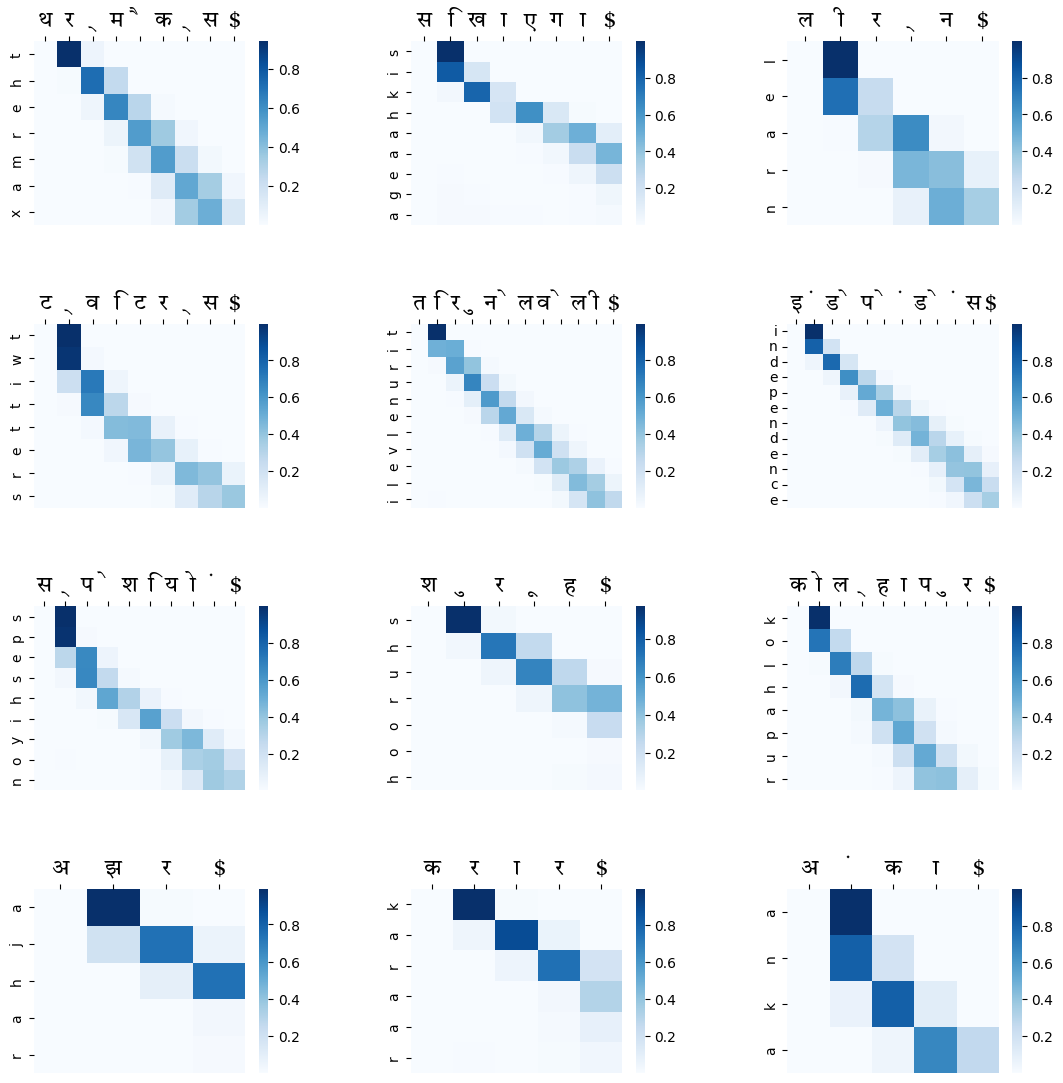

In [70]:
# Create a figure with a 3x3 grid and set the size to 12x12 inches
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

# Adjust the spacing between subplots
fig.tight_layout(pad=5.0)

# Flatten the axes into a 1-dimensional array
axes = axes.ravel()

# Iterate over each index up to 9
for i in range(0,12):
    # Get the attention weights for the corresponding input word
    attn_weight = attn_weights[i].cpu().detach().numpy()
    attn_weight = attn_weight[1:len(input_w[i]) + 1,2:len(output[i])+2]
    # Plot the attention weights as a heatmap on the current axis
    sns.heatmap(attn_weight, ax=axes[i],cmap= "Blues")

    # Set the y-axis tick labels to the input words
    axes[i].set_yticklabels(input_w[i])

    # Set the x-axis tick labels to the output words
    axes[i].set_xticklabels(output[i][1:]+'$', fontproperties=hindi_font, fontdict={'fontsize': 16})

    # Move the x-axis ticks to the top of the heatmap
    axes[i].xaxis.tick_top()

fig.canvas.draw()
image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

# wandb.log({"attention_heatmap_final": wandb.Image(image)})



In [44]:
!python train.py

python3: can't open file '/content/train.py': [Errno 2] No such file or directory


In [ ]:
!python train.py -dp aksharantar_sampled/ -la hin -e 5 -b 128 -lr 0.0001 -cl GRU -bd True -at True -do 0.2 -el 3 -dl 3 -es 16 -hls 128


In [71]:
import csv
 
# opening the CSV file
with open('predictions_attention.csv', mode ='r')as file:
   
  # reading the CSV file
  csvFile = csv.reader(file)
 
  # displaying the contents of the CSV file
  count = 0
  for lines in csvFile:
        if lines[1] == lines[2] :
          count = count+1


In [72]:
count

1661

In [56]:
input_w[2]

'learn'